In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data09/funda_train.csv')

df.store_id = df.store_id.astype(np.int32)
df.card_id = df.card_id.astype(np.int32)
df.card_company = df.card_company.astype('category')
df.transacted_date = pd.to_datetime(df.transacted_date + " " + df.transacted_time, format='%Y-%m-%d %H:%M')
df.installment_term = df.installment_term.astype(np.int16)
df.region = df.region.astype('category')
df.type_of_business = df.type_of_business.astype('category')

del df['transacted_time']

### 가설 1
- 시간에 따른 매출 변동이 얼마나 클까?

In [3]:
# 각 상점 별로 데이터가 존재하는 기간

In [4]:
store_period = (df.groupby('store_id').transacted_date.max() - df.groupby('store_id').transacted_date.min()).reset_index(name='period')

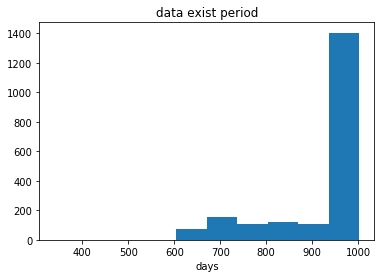

In [5]:
plt.hist(store_period.period.dt.days)
plt.title('data exist period')
plt.xlabel('days')
plt.show()

In [6]:
# 2018년에 폐점한 것으로 보이는 케이스
df[df.store_id==2119]

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
6492743,2119,4629260,c,2017-03-23 14:45:00,0,NaN,NaN,275000.000000
6492744,2119,4629261,a,2017-03-27 11:31:00,0,NaN,NaN,114285.714286
6492745,2119,2171166,d,2017-03-27 11:58:00,0,NaN,NaN,148571.428571
6492746,2119,4629262,d,2017-03-28 11:13:00,0,NaN,NaN,78571.428571
6492747,2119,4629263,a,2017-03-28 11:19:00,0,NaN,NaN,112000.000000
...,...,...,...,...,...,...,...,...
6492850,2119,4629273,c,2018-02-12 13:34:00,0,NaN,NaN,60000.000000
6492851,2119,4629260,c,2018-02-20 12:16:00,0,NaN,NaN,296428.571429
6492852,2119,4629276,d,2018-02-20 15:33:00,0,NaN,NaN,110000.000000
6492853,2119,4629261,a,2018-02-26 13:22:00,0,NaN,NaN,122857.142857


In [7]:
# 휴점을 오래하는 상점이 있는가? 데이터가 끊겼다가 다시 발생하는 게 흔한 것인가?

In [8]:
df.sort_values('transacted_date')

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
3314317,1091,2352113,f,2016-06-01 00:00:00,0,NaN,NaN,2428.571429
1116192,410,752611,b,2016-06-01 00:00:00,0,NaN,NaN,77142.857143
1712884,611,1184314,a,2016-06-01 00:00:00,0,서울 송파구,NaN,6571.428571
4902523,1609,3487137,b,2016-06-01 00:00:00,0,부산 사상구,NaN,7000.000000
1468641,534,1013865,a,2016-06-01 00:00:00,0,서울 서초구,NaN,11428.571429
...,...,...,...,...,...,...,...,...
5541618,1824,3938087,f,2019-02-28 23:58:00,0,NaN,NaN,4000.000000
5520065,1819,3923665,e,2019-02-28 23:58:00,0,부산 기장군,간이음식 포장 판매 전문점,2285.714286
1406927,513,972680,b,2019-02-28 23:59:00,0,NaN,NaN,54142.857143
3284999,1074,2315288,b,2019-02-28 23:59:00,0,NaN,NaN,6285.714286


In [9]:
from tqdm import tqdm 

In [10]:
max_time_diff = lambda group: (group.store_id.values[0], group.transacted_date.diff().max())

In [11]:
from joblib import Parallel, delayed
res = Parallel(n_jobs=14)(delayed(max_time_diff)(group) 
                         for _, group in tqdm(df.groupby('store_id'), total=df.store_id.nunique()))

100%|██████████| 1967/1967 [00:05<00:00, 369.41it/s]


In [12]:
max_diff_df = pd.DataFrame(res, columns=['store_id', 'max_diff'])

In [13]:
max_diff_df.nlargest(10, 'max_diff')

,store_id,max_diff
742,795,656 days 21:07:00
1117,1204,554 days 17:15:00
590,632,518 days 14:52:00
251,271,492 days 01:49:00
1912,2081,485 days 02:40:00
1563,1696,462 days 19:57:00
1691,1836,386 days 02:41:00
469,506,317 days 20:46:00
1643,1783,306 days 17:02:00
1260,1364,288 days 01:58:00


In [14]:
for days in (10, 50, 90, 150, 300):
    print(f"{days}일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: {(max_diff_df.max_diff>datetime.timedelta(days=days)).sum()}")

10일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 959
50일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 159
90일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 83
150일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 36
300일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 9


In [15]:
### 한 달 단위 상점 매출을 보자

In [16]:
sampled_stores = df.store_id.drop_duplicates().sample(5)

sampled_df = df[df.store_id.isin(sampled_stores)]
sampled_df = sampled_df.assign(transacted_month = sampled_df.transacted_date.dt.to_period("M").dt.to_timestamp())
sampled_grouped = sampled_df.groupby(['store_id', 'transacted_month']).amount.sum().reset_index(name='amount')

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


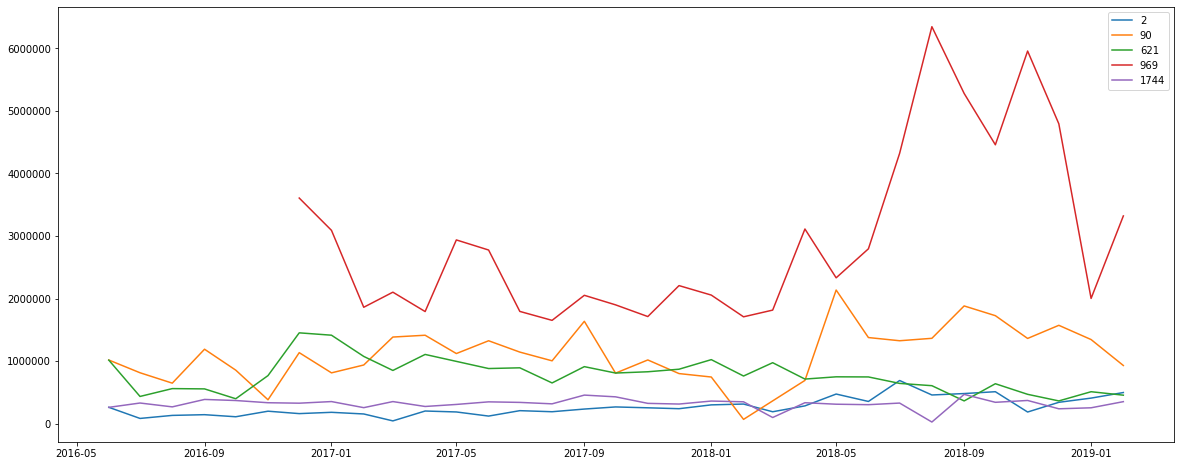

In [17]:
plt.figure(figsize=(20,8))
leg = []
for store_id, group in sampled_grouped.groupby('store_id'):
    plt.plot(group.transacted_month, group.amount)
    leg.append(store_id)
plt.legend(leg)
plt.show()

### type of business 별로 판매액이 다르다

In [18]:
df = df.assign(transacted_month = df.transacted_date.dt.to_period("M").dt.to_timestamp())

In [19]:
%%time
business_group = df.groupby(['store_id', 'transacted_month']).amount.sum().dropna().reset_index(name='amount')
business_group = business_group.groupby('store_id').amount.mean().reset_index(name='amount') # 각 상점 별 평균 월판매금액

CPU times: user 1.72 s, sys: 289 ms, total: 2.01 s
Wall time: 421 ms


In [20]:
business_group = business_group.merge(df[['store_id', 'type_of_business']].drop_duplicates().dropna(), on='store_id')

In [21]:
business_group_amount = business_group.groupby('type_of_business').amount.mean()

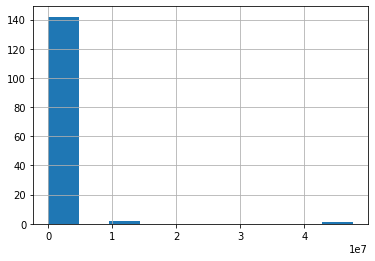

In [22]:
business_group_amount.hist()

In [23]:
business_group_amount = business_group_amount.reset_index(name='amount')

In [24]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [25]:
business_group_amount = (
    business_group_amount.merge(
        df.groupby('type_of_business').store_id.nunique().reset_index(name='store_count')
        , on='type_of_business')
)

In [26]:
business_group_amount.nlargest(10, 'amount')

,type_of_business,amount,store_count
101,의약품 도매업,47531520.03,1
106,일반 병원,10937807.79,1
36,기타 산업용 농산물 도매업,9665114.72,1
83,안경 및 안경렌즈 제조업,4249680.09,1
69,속옷 및 잠옷 소매업,3902221.21,1
64,상품 종합 도매업,3605705.85,2
135,"페인트, 창호 및 기타 건설자재 소매업",3507135.93,1
9,경영 컨설팅업,3398826.02,1
87,여행사업,2759418.17,2
70,수산물 가공식품 도매업,2731020.76,1


### split data into train and test

In [27]:
train_df = df[df.transacted_date < datetime.date(2018, 11, 1)]
test_df = df[~(df.transacted_date < datetime.date(2018, 11, 1))]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [28]:
train_df

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount,transacted_month
0,0,0,b,2016-06-01 13:13:00,0,NaN,기타 미용업,1857.14,2016-06-01
1,0,1,h,2016-06-01 18:12:00,0,NaN,기타 미용업,857.14,2016-06-01
2,0,2,c,2016-06-01 18:52:00,0,NaN,기타 미용업,2000.00,2016-06-01
3,0,3,a,2016-06-01 20:22:00,0,NaN,기타 미용업,7857.14,2016-06-01
4,0,4,c,2016-06-02 11:06:00,0,NaN,기타 미용업,2000.00,2016-06-01
...,...,...,...,...,...,...,...,...,...
6555176,2136,4661875,e,2018-10-31 01:38:00,0,제주 제주시,기타 주점업,8142.86,2018-10-01
6555177,2136,4663007,a,2018-10-31 19:20:00,0,제주 제주시,기타 주점업,2857.14,2018-10-01
6555178,2136,4662457,d,2018-10-31 22:07:00,0,제주 제주시,기타 주점업,3285.71,2018-10-01
6555179,2136,4663008,c,2018-10-31 23:19:00,0,제주 제주시,기타 주점업,10714.29,2018-10-01


In [29]:
y = test_df.groupby('store_id').amount.sum()

### 새로운 모델
- 최근 1개월을 가지고 해보자: feature1
- type_of_business 별로 봐보자: feature2
- 평균 할부 개월수installment_term: feature3
- 최빈 카드사: card_company

- 최근 3개월간의 data를 test로 잘라서 모형을 학습한 뒤, 전체를 다시 학습해 예측해보자

**feature 1**

In [30]:
# recent 3 months sell amount
recent_df = train_df[train_df.transacted_date >= datetime.datetime(2018, 10, 1)]
recent_amount = recent_df.groupby(['store_id']).amount.sum().reset_index(name='amount').dropna()

**feature 2**

In [31]:
assert df.groupby('store_id').type_of_business.nunique().max() == 1 # 각 상점 별로 분야는 최대 1개
store_business_type = train_df[['store_id', 'type_of_business']].drop_duplicates().dropna()

**feature 3**

In [32]:
installment = train_df.groupby('store_id').installment_term.mean().reset_index(name='installment')

**feature 4**

In [33]:
%%time
# 최빈값이 여러 개일 경우 중복이 있을 수 있음
store_most_card = train_df.groupby('store_id')['card_company'].agg(pd.Series.mode).reset_index(name='card_company')
store_most_card = store_most_card.drop_duplicates('store_id')

del store_most_card['level_1']

CPU times: user 1.39 s, sys: 58.4 ms, total: 1.45 s
Wall time: 1.45 s


### aggregation and modeling
- 이하는 원래 함수화하는 것이 좋다

In [34]:
# feature aggregation
train_feature = (
    recent_amount.merge(
        store_business_type, on='store_id', how='outer')
    .merge(
        installment, on='store_id', how='outer')
    .merge(
        store_most_card, on='store_id', how='outer')
)

# fill na
train_feature.amount = train_feature.amount.fillna(0)
train_feature.type_of_business = train_feature.type_of_business.astype('object').fillna('missing')

# category to dummy
train_dummy = pd.concat([
    pd.get_dummies(train_feature.type_of_business, prefix='type_of_business'),
    pd.get_dummies(train_feature.card_company, prefix='card_company')
], axis=1)

In [35]:
# aggregation
X = pd.concat([train_dummy, train_feature[['store_id', 'amount', 'installment']]], axis=1)

# data which exist in both X and y
inter_store_id = set(X.store_id) & set(y.index)

X = X[X.store_id.isin(inter_store_id)]
y = y[y.index.isin(inter_store_id)]

X = X.set_index('store_id')

In [36]:
X.head()

,type_of_business_missing,type_of_business_가구 소매업,type_of_business_가전제품 소매업,type_of_business_가정용 세탁업,type_of_business_가정용 직물제품 소매업,type_of_business_간이음식 포장 판매 전문점,type_of_business_간판 및 광고물 제조업,type_of_business_건강보조식품 소매업,"type_of_business_게임용구, 인형 및 장난감 소매업",type_of_business_결혼 상담 및 준비 서비스업,...,card_company_a,card_company_b,card_company_c,card_company_d,card_company_e,card_company_f,card_company_g,card_company_h,amount,installment
store_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,739000.00,0.12
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,95000.00,0.00
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,510000.00,0.22
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,828428.57,0.04
5,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,324928.57,0.20


In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
clf = RandomForestRegressor(random_state=85)
clf.fit(X, y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=85, verbose=0,
                      warm_start=False)

### 전체 데이터에 대해 feature 생성

In [40]:
# recent 3 months sell amount
recent_df = df[df.transacted_date >= datetime.datetime(2019, 2, 1)]
recent_amount = recent_df.groupby(['store_id']).amount.sum().reset_index(name='amount').dropna()

assert df.groupby('store_id').type_of_business.nunique().max() == 1 # 각 상점 별로 분야는 최대 1개
store_business_type = df[['store_id', 'type_of_business']].drop_duplicates().dropna()


installment = df.groupby('store_id').installment_term.mean().reset_index(name='installment')

# 최빈값이 여러 개일 경우 중복이 있을 수 있음
store_most_card = df.groupby('store_id')['card_company'].agg(pd.Series.mode).reset_index(name='card_company')
store_most_card = store_most_card.drop_duplicates('store_id')

del store_most_card['level_1']

In [41]:
recent_amount

,store_id,amount
0,0,515285.71
1,1,77428.57
2,2,496857.14
3,4,882285.71
4,5,215514.29
...,...,...
1921,2132,630428.57
1922,2133,116285.71
1923,2134,166000.00
1924,2135,404285.71


In [42]:
train_feature = (
    recent_amount.merge(
        store_business_type, on='store_id', how='outer')
    .merge(
        installment, on='store_id', how='outer')
    .merge(
        store_most_card, on='store_id', how='outer')
)

train_feature.amount = train_feature.amount.fillna(0)
train_feature.type_of_business = train_feature.type_of_business.astype('object').fillna('missing')

train_dummy = pd.concat([
    pd.get_dummies(train_feature.type_of_business, prefix='type_of_business'),
    pd.get_dummies(train_feature.card_company, prefix='card_company')
], axis=1)

X = pd.concat([train_dummy, train_feature[['store_id', 'amount', 'installment']]], axis=1)

inter_store_id = set(X.store_id) & set(y.index)

X = X[X.store_id.isin(inter_store_id)]
y = y[y.index.isin(inter_store_id)]

X = X.set_index('store_id')

In [43]:
y_pred = pd.DataFrame(clf.predict(X), columns = ['amount']).assign(store_id = X.index)

In [44]:
y_pred

,amount,store_id
0,3772658.57,0
1,3525457.14,1
2,2476149.20,2
3,3009620.20,4
4,2388961.43,5
...,...,...
1951,1444461.43,1598
1952,2198692.86,1983
1953,2081258.57,2027
1954,1156359.86,2053


In [45]:
submit = pd.read_csv("data09/submission.csv")
submit = submit[['store_id']].merge(y_pred, on='store_id', how='left')
submit.amount = submit.amount.fillna(0)

In [46]:
submit.to_csv('data09/random_forest.csv', index=False)

In [47]:
print(f"RF SCORE: {3662872.694785049:.2f}")
print(f"BASELINE SCORE: {821368.3424434928:.2f}")

RF SCORE: 3662872.69
BASELINE SCORE: 821368.34
